In [73]:
import simtk.openmm.app as app
import simtk.openmm as openmm
import simtk.unit as unit
from pkg_resources import resource_filename
import numpy as np
import os

from openmmtools.constants import kB
from perses.utils.smallmolecules import render_protein_residue_atom_mapping
from perses.rjmc import topology_proposal
from perses.rjmc.topology_proposal import append_topology
from perses.rjmc.topology_proposal import PointMutationEngine
from perses.rjmc.atom_mapping import AtomMapper, InvalidMappingException

from openmmforcefields.generators import SystemGenerator
import copy 

temperature = 300*unit.kelvin
# Compute kT and inverse temperature.
kT = kB * temperature
beta = 1.0 / kT
ENERGY_THRESHOLD = 1e-6
PROHIBITED_RESIDUES = ['CYS']

In [146]:
#### Generate old topology, positions, system
res_name = 'asn'
pdb = app.PDBFile(f"../../input/{res_name.lower()}_vacuum.pdb")
topology = pdb.topology
positions = unit.quantity.Quantity(value=np.array([list(atom_pos) for atom_pos in pdb.positions.value_in_unit_system(unit.md_unit_system)]), unit=unit.nanometers)

system_generator = SystemGenerator(['amber14/protein.ff14SB.xml'],
                               barostat=None,
                               forcefield_kwargs={'removeCMMotion': False,
                                                    'ewaldErrorTolerance': 1e-4,
                                                    'constraints' : app.HBonds,
                                                    'hydrogenMass' : 4 * unit.amus},
                                nonperiodic_forcefield_kwargs={'nonbondedMethod': app.NoCutoff},
                                small_molecule_forcefield='gaff-2.11',
                                molecules=None,
                                cache=None)

system = system_generator.create_system(topology) # Update the parametrization scheme to amberff14sb


#### Generate inputs for _construct_atom_map()
from perses.rjmc.topology_proposal import PointMutationEngine
new_res = 'ARG'
point_mutation_engine = PointMutationEngine(wildtype_topology=topology,
                                            system_generator=system_generator,
                                            chain_id='A', # Denote the chain id allowed to mutate (it's always a string variable)
                                            max_point_mutants=1,
                                            residues_allowed_to_mutate=['2'], # The residue ids allowed to mutate
                                            allowed_mutations=[('2', new_res)], # The residue ids allowed to mutate with the three-letter code allowed to change
                                            aggregate=True) # Always allow aggregation

old_topology = app.Topology()
append_topology(old_topology, topology)

new_topology = app.Topology()
append_topology(new_topology, topology)

# Check that old_topology and old_system have same number of atoms.
old_system = system
old_topology_natoms = old_topology.getNumAtoms()  # number of topology atoms
old_system_natoms = old_system.getNumParticles()
if old_topology_natoms != old_system_natoms:
    msg = 'PolymerProposalEngine: old_topology has %d atoms, while old_system has %d atoms' % (old_topology_natoms, old_system_natoms)
    raise Exception(msg)

old_chemical_state_key = point_mutation_engine.compute_state_key(old_topology)
metadata = dict()
index_to_new_residues, metadata = point_mutation_engine._choose_mutant(old_topology, metadata)
residue_map = point_mutation_engine._generate_residue_map(old_topology, index_to_new_residues)

for (res, new_name) in residue_map:
    if res.name == new_name:
        #remove the index_to_new_residues entries where the topology is already mutated
        del(index_to_new_residues[res.index])

chosen_res_index = list(index_to_new_residues.keys())[0]
# Add modified_aa property to residues in old topology
for res in old_topology.residues():
    res.modified_aa = True if res.index in index_to_new_residues.keys() else False

# Identify differences between old topology and proposed changes
# excess_atoms : list(simtk.openmm.app.topology.Atom) atoms from existing residue not in new residue
# excess_bonds : list(tuple (simtk.openmm.app.topology.Atom, simtk.openmm.app.topology.Atom)) bonds from existing residue not in new residue
# missing_bonds : list(tuple (simtk.openmm.app.topology._TemplateAtomData, simtk.openmm.app.topology._TemplateAtomData)) bonds from new residue not in existing residue
excess_atoms, excess_bonds, missing_atoms, missing_bonds = point_mutation_engine._identify_differences(old_topology, residue_map)

# Delete excess atoms and bonds from old topology
excess_atoms_bonds = excess_atoms + excess_bonds
new_topology = point_mutation_engine._delete_atoms(old_topology, excess_atoms_bonds)

# Add missing atoms and bonds to new topology
new_topology = point_mutation_engine._add_new_atoms(new_topology, missing_atoms, missing_bonds, residue_map)

DEBUG:openmmforcefields.system_generators:Trying GAFFTemplateGenerator to load gaff-2.11


In [147]:
class AtomMapper2(AtomMapper):
    def _create_atom_mapping(old_oemol, new_oemol, match, matching_criterion):
        """
        Returns an AtomMapping that omits hydrogen-to-nonhydrogen atom maps
        as well as any X-H to Y-H where element(X) != element(Y) or aromatic(X) != aromatic(Y)
        Parameters
        ----------
        old_oemol : openeye.oechem.OEMol object
            The old molecules
        new_oemol : openeye.oechem.OEMol object
            The new molecule
        match : openeye.oechem.OEMatchBase iterable
            entry in oechem.OEMCSSearch.Match object
        matching_criterion : str
            Matching criterion for _create_pattern_to_target_map.
            whether the pattern to target map is chosen based on atom indices or names (which should be uniquely defined)
            allowables: ['index', 'name']
        Returns
        -------
        atom_mapping : AtomMapping
            The atom mapping
        """
        # TODO : Overhaul this to use OpenFF Molecule
        import openeye.oechem as oechem
        new_to_old_atom_map = dict()
        pattern_to_target_map = AtomMapper._create_pattern_to_target_map(old_oemol, new_oemol, match, matching_criterion)
        for pattern_oeatom, target_oeatom in pattern_to_target_map.items():
            old_index, new_index = pattern_oeatom.GetIdx(), target_oeatom.GetIdx()
            old_oeatom, new_oeatom = pattern_oeatom, target_oeatom

            # Check if a hydrogen was mapped to a non-hydrogen (basically the xor of is_h_a and is_h_b)
            if (old_oeatom.GetAtomicNum() == 1) != (new_oeatom.GetAtomicNum() == 1):
                continue

#             # Check if X-H to Y-H changes where element(X) != element(Y) or aromatic(X) != aromatic(Y)
#             if (
#                 (old_oeatom.GetAtomicNum() == 1) and (new_oeatom.GetAtomicNum() == 1)
#                 # Handle the weird special case where the molecule is just one hydrogen atom
#                 # (which is an abuse that occurs in the current biopolymer logic)
#                 # TODO: Fix this when we overhaul biopolymer logic
#                 and (old_oeatom.GetDegree() > 0) and (new_oeatom.GetDegree() == 1)
#                ):

#                 X = [ bond.GetNbr(old_oeatom) for bond in old_oeatom.GetBonds() ][0]
#                 Y = [ bond.GetNbr(new_oeatom) for bond in new_oeatom.GetBonds() ][0]
#                 if ( X.GetAtomicNum() != Y.GetAtomicNum() ) or ( X.IsAromatic() != Y.IsAromatic() ):
#                     continue

            new_to_old_atom_map[new_index] = old_index

        return AtomMapping(old_oemol, new_oemol, new_to_old_atom_map=new_to_old_atom_map)


In [148]:
import openeye.oechem as oechem

In [149]:
# atom_map : dict, key : int (index of atom in old topology) , value : int (index of same atom in new topology)
# atom_map = dict()

# atoms with an old_index attribute should be mapped
# k : int
# atom : simtk.openmm.app.topology.Atom



In [150]:
# old_to_new_residues : dict, key : str old residue name, key : simtk.openmm.app.topology.Residue new residue
old_to_new_residues = {}
new_residues = [residue for residue in new_topology.residues()] # Assumes all residue indices start from 0 and are contiguous
for old_residue in old_topology.residues():
    old_to_new_residues[old_residue] = new_residues[old_residue.index]

In [151]:
# # modified_residues : dict, key : index of old residue, value : proposed residue
# modified_residues = dict()

# for map_entry in residue_map:
#     old_residue = map_entry[0]
#     modified_residues[old_residue.index] = old_to_new_residues[old_residue]

# # old_residues : dict, key : index of old residue, value : old residue
# old_residues = dict()
# for residue in old_topology.residues():
#     if residue.index in index_to_new_residues.keys():
#         old_residues[residue.index] = residue

# # Update atom map with atom mappings for residues that have been modified
# assert len(index_to_new_residues) == 1, f"index_to_new_residues is not of length 1"
# index = list(index_to_new_residues.keys())[0]
# #old_res = old_residues[index]
# old_res = old_residues[index]
# new_res = modified_residues[index]




In [152]:
old_res = residue_map[0][0]
new_res = old_to_new_residues[old_res]

old_res_name = old_res.name
new_res_name = new_res.name

new_res_index_to_name = {atom.index: atom.name for atom in new_res.atoms()}
old_res_index_to_name = {atom.index: atom.name for atom in old_res.atoms()}


In [153]:
current_residue_pdb_filename = resource_filename('perses', os.path.join('data', 'amino_acid_templates', f"{old_res_name}.pdb"))
proposed_residue_pdb_filename = resource_filename('perses', os.path.join('data', 'amino_acid_templates', f"{new_res_name}.pdb"))

current_oemol = PointMutationEngine.generate_oemol_from_pdb_template(current_residue_pdb_filename)
proposed_oemol = PointMutationEngine.generate_oemol_from_pdb_template(proposed_residue_pdb_filename)

old_oemol_res_copy = copy.deepcopy(current_oemol)
new_oemol_res_copy = copy.deepcopy(proposed_oemol)

# #create bookkeeping dictionaries
# old_res_to_oemol_map = {atom.index: current_oemol.GetAtom(oechem.OEHasAtomName(atom.name)).GetIdx() for atom in old_res.atoms()}
# new_res_to_oemol_map = {atom.index: proposed_oemol.GetAtom(oechem.OEHasAtomName(atom.name)).GetIdx() for atom in new_res.atoms()}

# old_oemol_name_idx = {atom.GetName(): atom.GetIdx() for atom in current_oemol.GetAtoms()}
# new_oemol_name_idx = {atom.GetName(): atom.GetIdx() for atom in proposed_oemol.GetAtoms()}

# old_oemol_to_res_map = {val: key for key, val in old_res_to_oemol_map.items()}
# new_oemol_to_res_map = {val: key for key, val in new_res_to_oemol_map.items()}

In [154]:
# #now remove backbones in both molecules and map them separately
# # TODO: Why don't we just include backbone atoms and just enforce their mapping via external indices?
# backbone_atoms = ['C', 'CA', 'N', 'O', 'H', 'HA', "H'"]
# # TODO dom make this a seperate function
# old_atoms_to_delete, new_atoms_to_delete = [], []
# for atom in proposed_oemol.GetAtoms():
#     if atom.GetName() in backbone_atoms:
#         try: #to get the backbone atom with the same naem in the old_oemol_res
#             old_corresponding_backbones = [_atom for _atom in current_oemol.GetAtoms() if _atom.GetName() == atom.GetName()]
#             if old_corresponding_backbones == []:
#                 #this is an exception when the old oemol res is a glycine.  if this is the case, then we do not map HA2 or HA3
#                 assert set(['HA2', 'HA3']).issubset([_atom.GetName() for _atom in current_oemol.GetAtoms()]), f"old oemol residue is not a GLY template"
#                 #we have to map HA3 to HA (old, new)
#                 old_corresponding_backbones = [_atom for _atom in current_oemol.GetAtoms() if _atom.GetName() == 'HA3' and atom.GetName() == 'HA']
#             assert len(old_corresponding_backbones) == 1, f"there can only be one corresponding backbone in the old molecule; corresponding backbones: {[atom.GetName() for atom in old_corresponding_backbones]}"
#             old_corresponding_backbone = old_corresponding_backbones[0]
#             if not atom.GetName() == "H'": #throw out the extra H
#                 local_atom_map[atom.GetIdx()] = old_corresponding_backbone.GetIdx()
#             old_atoms_to_delete.append(old_corresponding_backbone)
#             new_atoms_to_delete.append(atom)
#             assert proposed_oemol.DeleteAtom(atom), f"failed to delete new_oemol atom {atom}"
#             assert current_oemol.DeleteAtom(old_corresponding_backbone), f"failed to delete old_oemol atom {old_corresponding_backbone}"
#         except Exception as e:
#             raise Exception(f"failed to map the backbone separately: {e}")

# old_sidechain_oemol_indices_to_name = {atom.GetIdx(): atom.GetName() for atom in current_oemol.GetAtoms()}
# new_sidechain_oemol_indices_to_name = {atom.GetIdx(): atom.GetName() for atom in proposed_oemol.GetAtoms()}

#now we can get the mol atom map of the sidechain
#NOTE: since the sidechain oemols are NOT zero-indexed anymore, we need to match by name (since they are unique identifiers)
ring_aas = ['TRP', 'TYR', 'PHE', 'HIS', 'HID', 'HIE', 'HIP']
break_bool = False if old_res_name in ring_aas or new_res_name in ring_aas else True

# atom_mapper = AtomMapper2(map_strength='default', matching_criterion='name', allow_ring_breaking=break_bool)
# atom_mapping = atom_mapper.get_all_mappings(current_oemol, proposed_oemol)

# #check the atom map thus far:
# _logger.debug(f"\t\t\tlocal atom map nonstereo sidechain: {atom_mapping}")

# #preserve chirality of the sidechain
# # _logger.warning(f"\t\t\told oemols: {[atom.GetIdx() for atom in self.current_molecule.GetAtoms()]}")
# # _logger.warning(f"\t\t\tnew oemols: {[atom.GetIdx() for atom in new_oemol_res.GetAtoms()]}")
# # TODO: Should this be done here, or automatically in the mapping generation?
# if atom_mapping is not None:
#     atom_mapping.preserve_chirality()
# else:
#     atom_mapping = dict()

# _logger.debug(f"\t\t\tlocal atom map stereo sidechain: {atom_mapping}")

# # DEBUG
# _logger.info(atom_mapping.old_mol.atoms)
# _logger.info(atom_mapping.new_mol.atoms)

# #fix the sidechain indices w.r.t. full oemol
# # TODO: Glue AtomMapping in more broadly
# sidechain_fixed_map = {}
# mapped_names = []
# backbone_atoms = ['N', 'H', 'C', 'O', 'CA', 'HA']
# sidechain_atom_indices = []
# for new_sidechain_idx, old_sidechain_idx in atom_mapping.new_to_old_atom_map.items():
#     try:
#         new_name, old_name = atom_mapping.new_mol.atoms[new_sidechain_idx].name, atom_mapping.old_mol.atoms[old_sidechain_idx].name
#         mapped_names.append((new_name, old_name))
#         new_full_oemol_idx, old_full_oemol_idx = new_oemol_name_idx[new_name], old_oemol_name_idx[old_name]
#         if new_name not in backbone_atoms:
#             sidechain_atom_indices.append(new_full_oemol_idx)
#         sidechain_fixed_map[new_full_oemol_idx] = old_full_oemol_idx
#     except KeyError as e:
#         # Report more information on failure
#         atom_mapping.render_image('failure.png')
#         raise Exception(f'{atom_mapping}\n{e}')

# _logger.debug(f"\t\t\toemol sidechain fixed map: {sidechain_fixed_map}")

# if ignore_sidechain_atoms:
#     for index in sidechain_atom_indices:
#         del[sidechain_fixed_map[index]]

# _logger.debug(f"\t\t\tthe local atom map (backbone) is {local_atom_map}")
# #update the local map
# local_atom_map.update(sidechain_fixed_map)
# _logger.debug(f"\t\t\tthe local atom map (total) is {local_atom_map}")

# #correct the map
# #now we have to update the atom map indices
# _logger.debug(f"\t\t\tadjusting the atom map with topology indices...")
# topology_index_map = {}
# for new_oemol_idx, old_oemol_idx in local_atom_map.items():
#     topology_index_map[new_oemol_to_res_map[new_oemol_idx]] = old_oemol_to_res_map[old_oemol_idx]

# _logger.debug(f"\t\t\ttopology_atom_map: {topology_index_map}")

# mapped_atoms = [(new_res_index_to_name[new_idx], old_res_index_to_name[old_idx]) for new_idx, old_idx in topology_index_map.items()]
# _logger.debug(f"\t\t\tthe mapped atom names are: {mapped_atoms}")

#     #and all of the environment atoms should already be handled
# return topology_index_map, old_res_to_oemol_map, new_res_to_oemol_map, local_atom_map, current_oemol, proposed_oemol, old_oemol_res_copy, new_oemol_res_copy


In [155]:
def render_image(molecule1, molecule2, new_to_old_atom_map):
    from openeye import oechem, oedepict
    width = 1200
    height = 600
    filename = None
    format = 'png'

#     # Handle format
#     if format is None:
#         if filename is not None:
#             format = oechem.OEGetFileExtension(filename)
#         else:
#             format = 'png'
#     if not oedepict.OEIsRegisteredImageFile(format):
#         raise ValueError(f'Unknown image type {format}')

    oechem.OEGenerate2DCoordinates(molecule1)
    oechem.OEGenerate2DCoordinates(molecule2)

    # Add both to an OEGraphMol reaction
    rmol = oechem.OEGraphMol()
    rmol.SetRxn(True)
    def add_molecule(mol):
        # Add atoms
        new_atoms = list()
        old_to_new_atoms = dict()
        for old_atom in mol.GetAtoms():
            new_atom = rmol.NewAtom(old_atom.GetAtomicNum())
            new_atom.SetFormalCharge(old_atom.GetFormalCharge())
            new_atoms.append(new_atom)
            old_to_new_atoms[old_atom] = new_atom
        # Add bonds
        for old_bond in mol.GetBonds():
            rmol.NewBond(old_to_new_atoms[old_bond.GetBgn()], old_to_new_atoms[old_bond.GetEnd()], old_bond.GetOrder())
        return new_atoms, old_to_new_atoms

    [new_atoms_1, old_to_new_atoms_1] = add_molecule(molecule1)
    [new_atoms_2, old_to_new_atoms_2] = add_molecule(molecule2)

    # Label reactant and product
    for atom in new_atoms_1:
        atom.SetRxnRole(oechem.OERxnRole_Reactant)
    for atom in new_atoms_2:
        atom.SetRxnRole(oechem.OERxnRole_Product)

    core1 = oechem.OEAtomBondSet()
    core2 = oechem.OEAtomBondSet()
    # add all atoms to the set
    core1.AddAtoms(new_atoms_1)
    core2.AddAtoms(new_atoms_2)
    # Label mapped atoms
    core_change = oechem.OEAtomBondSet()
    index =1
    for (index2, index1) in new_to_old_atom_map.items():
        new_atoms_1[index1].SetMapIdx(index)
        new_atoms_2[index2].SetMapIdx(index)
        # now remove the atoms that are core, so only uniques are highlighted
        core1.RemoveAtom(new_atoms_1[index1])
        core2.RemoveAtom(new_atoms_2[index2])
        if new_atoms_1[index1].GetAtomicNum() != new_atoms_2[index2].GetAtomicNum():
            # this means the element type is changing
            core_change.AddAtom(new_atoms_1[index1])
            core_change.AddAtom(new_atoms_2[index2])
        index += 1
    # Set up image options
    itf = oechem.OEInterface()
    oedepict.OEConfigureImageOptions(itf)

    # Setup depiction options
    oedepict.OEConfigure2DMolDisplayOptions(itf, oedepict.OE2DMolDisplaySetup_AromaticStyle)
    opts = oedepict.OE2DMolDisplayOptions(width, height, oedepict.OEScale_AutoScale)
    oedepict.OESetup2DMolDisplayOptions(opts, itf)
    opts.SetBondWidthScaling(True)
    opts.SetAtomPropertyFunctor(oedepict.OEDisplayAtomMapIdx())
    opts.SetAtomColorStyle(oedepict.OEAtomColorStyle_WhiteMonochrome)

    # Depict reaction with component highlights
    oechem.OEGenerate2DCoordinates(rmol)
    display = oedepict.OE2DMolDisplay(rmol, opts)

    if core1.NumAtoms() != 0:
        oedepict.OEAddHighlighting(display, oechem.OEColor(oechem.OEPink),oedepict.OEHighlightStyle_Stick, core1)
    if core2.NumAtoms() != 0:
        oedepict.OEAddHighlighting(display, oechem.OEColor(oechem.OEPurple),oedepict.OEHighlightStyle_Stick, core2)
    if core_change.NumAtoms() != 0:
        oedepict.OEAddHighlighting(display, oechem.OEColor(oechem.OEGreen),oedepict.OEHighlightStyle_Stick, core_change)

    if filename is not None:
        ofs = oechem.oeofstream()
        if not ofs.open(filename):
            raise Exception('Cannot open output file %s' % filename)
        oedepict.OERenderMolecule(ofs, format, display)
        ofs.close()
    else:
        from IPython.display import Image
        oeimage = oedepict.OEImage(width, height)
        oedepict.OERenderMolecule(oeimage, display)
        string = oedepict.OEWriteImageToString(format, oeimage)
        return Image(string)

In [156]:
from openeye import oechem

pattern = current_oemol
target = proposed_oemol

# atomexpr = oechem.OEExprOpts_AutomorphAtoms
atomexpr = oechem.OEExprOpts_Valence 
# atomexpr = oechem.OEExprOpts_Valence | oechem.OEExprOpts_Hybridization | oechem.OEExprOpts_Aromaticity
# bondexpr = oechem.OEExprOpts_AutomorphBonds
bondexpr = oechem.OEExprOpts_BondOrder | oechem.OEExprOpts_EqSingleDouble 
# create maximum common substructure object
mcss = oechem.OEMCSSearch(pattern, atomexpr, bondexpr, oechem.OEMCSType_Approximate)
# set scoring function
mcss.SetMCSFunc(oechem.OEMCSMaxBondsCompleteCycles())
unique = True
# loop over matches

for count, match in enumerate(mcss.Match(target, unique)):
    d_map = {}
    print("Match %d:" % (count + 1))
    print("pattern atoms:", end=" ")
    for ma in match.GetAtoms():
        print(ma.pattern.GetIdx(), end=" ")
        d_map[ma.target.GetIdx()] = ma.pattern.GetIdx()
    print("\ntarget atoms: ", end=" ")
    for ma in match.GetAtoms():
        print(ma.target.GetIdx(), end=" ")


Match 1:
pattern atoms: 0 1 2 3 4 5 8 9 10 11 14 
target atoms:  0 1 2 3 4 5 11 12 13 14 24 Match 2:
pattern atoms: 1 2 3 4 5 6 9 10 11 12 14 
target atoms:  4 1 0 5 6 7 14 15 16 19 12 Match 3:
pattern atoms: 1 2 3 4 5 6 9 10 11 12 14 
target atoms:  4 1 0 5 6 7 13 15 16 19 12 Match 4:
pattern atoms: 1 2 3 4 5 6 9 10 11 13 14 
target atoms:  4 1 0 5 6 7 14 16 15 19 12 Match 5:
pattern atoms: 1 2 3 4 5 6 9 10 11 13 14 
target atoms:  4 1 0 5 6 7 13 16 15 19 12 

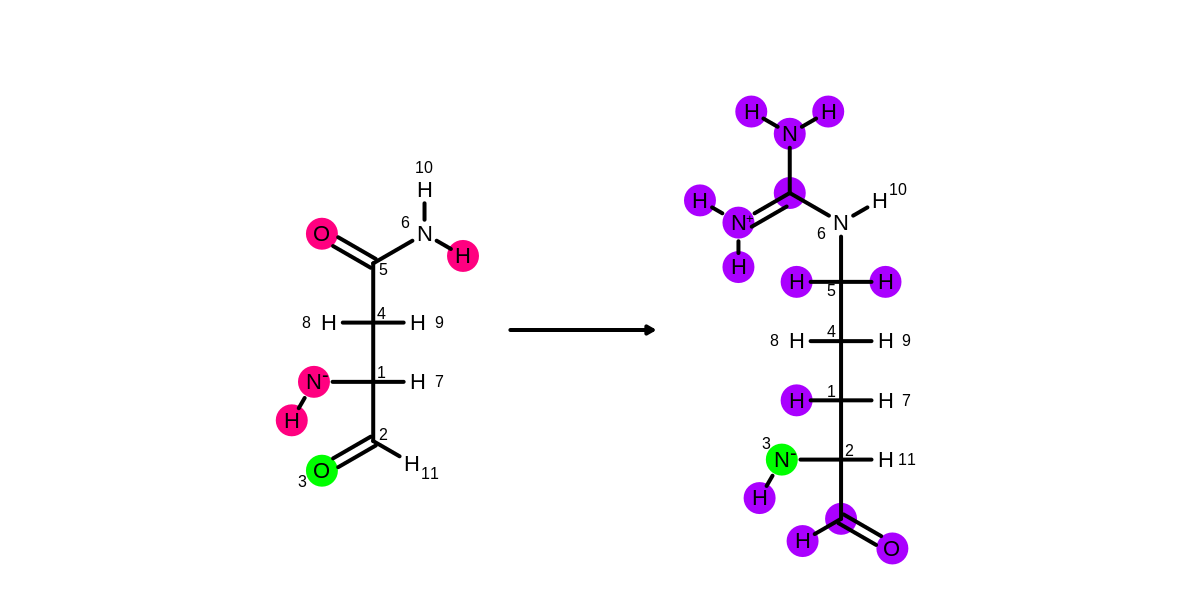

In [157]:
render_image(current_oemol, proposed_oemol, d_map)

In [ ]:
len(atom_mapping)

AtomMapping : [H:15][C:3](=[O:4])[C@:2]([H:10])([C:5]([H:11])([H:12])[C:6](=[O:8])[N:7]([H:13])[H:14])[N-:1][H:9] -> [H:17][c:7]1[c:9]([c:11]([c:10]([c:8]([c:6]1[C:5]([H:15])([H:16])[C@@:2]([H:14])([C:3](=[O:4])[H:22])[N-:1][H:13])[H:18])[H:20])[O:12][H:21])[H:19] : mapped atoms {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 8: 12, 9: 13, 10: 14, 14: 21}


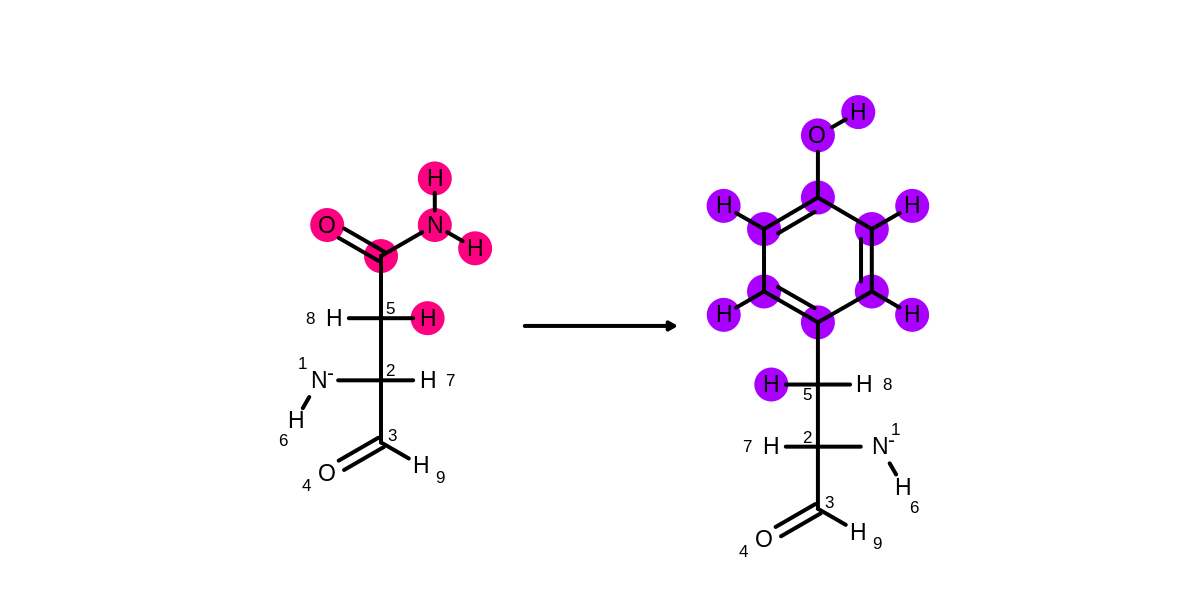

In [55]:
atom_mapping[0]

In [22]:
for atom_map in atom_mapping:
    print(atom_map)

AtomMapping : [H:15][C:3](=[O:4])[C@:2]([H:10])([C:5]([H:11])([H:12])[C:6](=[O:8])[N:7]([H:13])[H:14])[N-:1][H:9] -> [H:17][c:7]1[c:9]([c:11]([c:10]([c:8]([c:6]1[C:5]([H:15])([H:16])[C@@:2]([H:14])([C:3](=[O:4])[H:22])[N-:1][H:13])[H:18])[H:20])[O:12][H:21])[H:19] : mapped atoms {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 8: 12, 9: 13, 10: 14, 14: 21}
AtomMapping : [H:15][C:3](=[O:4])[C@:2]([H:10])([C:5]([H:11])([H:12])[C:6](=[O:8])[N:7]([H:13])[H:14])[N-:1][H:9] -> [H:17][c:7]1[c:9]([c:11]([c:10]([c:8]([c:6]1[C:5]([H:15])([H:16])[C@@:2]([H:14])([C:3](=[O:4])[H:22])[N-:1][H:13])[H:18])[H:20])[O:12][H:21])[H:19] : mapped atoms {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 8: 12, 9: 13, 11: 14, 14: 21}


In [21]:
oemol_map = atom_mapping.new_to_old_atom_map

# Remove H' , as this is not present in the openmm residue
# TODO: modify this to use atom_mapping.new_mol?
new_index_to_remove = [atom.GetIdx() for atom in proposed_oemol.GetAtoms() if atom.GetName() == "H'"][0]
del oemol_map[new_index_to_remove]

AttributeError: 'list' object has no attribute 'new_to_old_atom_map'

In [ ]:
# generate mapping to help get oemol atom indices to openmm atom indices
old_res_to_oemol_map = {atom.index: current_oemol.GetAtom(oechem.OEHasAtomName(atom.name)).GetIdx() for atom in old_res.atoms()}
new_res_to_oemol_map = {atom.index: proposed_oemol.GetAtom(oechem.OEHasAtomName(atom.name)).GetIdx() for atom in new_res.atoms()}

# old_oemol_name_idx = {atom.GetName(): atom.GetIdx() for atom in current_oemol.GetAtoms()}
# new_oemol_name_idx = {atom.GetName(): atom.GetIdx() for atom in proposed_oemol.GetAtoms()}

old_oemol_to_res_map = {val: key for key, val in old_res_to_oemol_map.items()}
new_oemol_to_res_map = {val: key for key, val in new_res_to_oemol_map.items()}

In [ ]:
# Convert oemol map to use openmm indices
openmm_map = [(new_oemol_to_res_map[new_idx], old_oemol_to_res_map[old_idx]) for new_idx, old_idx in oemol_map.items()]


In [ ]:
# Get names for each map
name_map = [(new_res_index_to_name[new_idx], old_res_index_to_name[old_idx]) for new_idx, old_idx in openmm_map]

In [ ]:
name_map